In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_02 import *
import torch.nn.functional as F

In [3]:
mpl.rcParams['image.cmap'] = 'gray'

In [4]:
x_train, y_train, x_valid, y_valid = get_data()

In [5]:
n_data,input_dim = x_train.shape
n_class = y_train.max()+1
hid_dim = 50

In [6]:
class Model(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super().__init__()
        self.layers = [nn.Linear(input_dim, hid_dim), nn.ReLU(), nn.Linear(hid_dim, output_dim)]
        
    def __call__(self, x):
        for l in self.layers: x=l(x)
        return x

In [7]:
model = Model(input_dim, hid_dim, 10)

In [8]:
x_train.shape

torch.Size([50000, 784])

In [9]:
pred = model(x_train)

In [10]:
pred

tensor([[-0.0382, -0.1076, -0.0844,  ...,  0.0555,  0.0768, -0.0209],
        [-0.0924, -0.1169,  0.0004,  ...,  0.0489,  0.0562, -0.0237],
        [-0.0640, -0.0548, -0.0828,  ...,  0.0403,  0.0469,  0.0179],
        ...,
        [-0.0542, -0.2227, -0.0232,  ...,  0.0431,  0.0271, -0.1417],
        [-0.0519, -0.1675, -0.0636,  ...,  0.0273,  0.0011,  0.0627],
        [-0.0691, -0.1988, -0.1204,  ...,  0.0672,  0.0684, -0.0464]],
       grad_fn=<AddmmBackward>)

## Cross entropy loss

First, we will need to compute the `softmax` of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$

In practice, we will need the **log of the softmax** when we calculate the loss.

In [11]:
def log_softmax(x): return (x.exp()/x.exp().sum(dim=-1,keepdim=True)).log()

In [12]:
sm_pred = log_softmax(pred)

In [13]:
sm_pred

tensor([[-2.3615, -2.4309, -2.4077,  ..., -2.2678, -2.2465, -2.3441],
        [-2.4189, -2.4434, -2.3261,  ..., -2.2776, -2.2703, -2.3502],
        [-2.3979, -2.3887, -2.4167,  ..., -2.2936, -2.2870, -2.3160],
        ...,
        [-2.3406, -2.5091, -2.3096,  ..., -2.2433, -2.2593, -2.4281],
        [-2.3698, -2.4853, -2.3814,  ..., -2.2906, -2.3167, -2.2551],
        [-2.3648, -2.4945, -2.4161,  ..., -2.2286, -2.2274, -2.3422]],
       grad_fn=<LogBackward>)

In [14]:
def nll(input, target): 
    
    return -input[range(target.shape[0]), target].mean()

In [15]:
loss = nll(sm_pred, y_train)

In [16]:
loss

tensor(2.3170, grad_fn=<NegBackward>)

**Note:** The formula

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$

gives a simplification when we compute the log softmax, which was previously defined as 

```py
(x.exp()/(x.exp().sum(-1,keepdim=True))).log()
```

In [17]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

In [18]:
test_near(nll(log_softmax(pred), y_train), loss)

Then, there is a way to compute the `log` of the sum of exponentials in a more stable way, called the `LogSumExp` trick. The idea is to use the following formula:

$$
\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )
$$

where a is the maximum of the $x_j$

In [19]:
def logsumexp(x):
    m = x.max(1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

In [20]:
test_near(logsumexp(pred), pred.logsumexp(1))

In [21]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [22]:
test_near(nll(log_softmax(pred), y_train), loss)

In [23]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [24]:
test_near(F.cross_entropy(pred, y_train), loss)

## Basic training loop
Basically the training loop repeats over the following steps:

- Get the output of the model on a batch of inputs
- Compare the output to the labels we have and compute a loss
- Calculate the gradients of the loss with respect to every parameter of the model
- Update said parameters with those gradients to make them a little bit better

In [25]:
loss_func = F.cross_entropy

In [26]:
#export
def accuracy(out: torch.Tensor, yb:torch.Tensor) -> torch.Tensor:
    return (torch.argmax(out, dim=1)==yb).float().mean()

In [27]:
batch_sz = 64

xb = x_train[:batch_sz]
yb = y_train[:batch_sz]
preds = model(xb)
preds[0], preds.shape

(tensor([-0.0382, -0.1076, -0.0844,  0.1018,  0.1022,  0.1481, -0.0628,  0.0555,
          0.0768, -0.0209], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [28]:
loss_func(preds, yb)

tensor(2.3260, grad_fn=<NllLossBackward>)

In [29]:
accuracy(preds, yb)

tensor(0.0625)

In [30]:
lr = 0.5   # learning rate
epochs = 2 # how many epochs to train for

In [31]:
import tqdm 

**tqdm tweak:**

I have modified the code of jeremy using a cool `tqdm` tweak from [Kaggle-Very Simple Pytorch Training by Abhishek Thakur](https://www.kaggle.com/abhishek/very-simple-pytorch-training-0-59)

- The tweak helps to print the running loss inside the `tqdm` progressbar

In [32]:
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch, epochs - 1))
    
    running_loss = 0.0
    counter = 0
    
    data_range = (n_data-1)// batch_sz + 1
    
    tk0 = tqdm.tqdm_notebook(range(data_range))
    
    for i in tk0:
        start_i = i*batch_sz
        end_i = start_i + batch_sz
        
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        
        preds = model(xb)
        loss = loss_func(preds, yb)
        
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()
                    
        running_loss += loss.item() * xb.size(0)
        counter += 1
        tk0.set_postfix(loss=(running_loss / (counter * batch_sz)))
        
    epoch_loss = running_loss / data_range
    print('Training Loss: {:.4f}'.format(epoch_loss))
    print("="*10)

Epoch 0/1



Training Loss: 20.5814
Epoch 1/1



Training Loss: 9.3083


In [33]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0096, grad_fn=<NllLossBackward>), tensor(1.))

## Using parameters and optim

**Parameters**

Use `nn.Module.__setattr__` and move `relu` to functional:

In [34]:
class Model(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, hid_dim)
        self.l2 = nn.Linear(hid_dim, output_dim)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))
        

In [35]:
model = Model(input_dim, hid_dim, 1)

In [36]:
for name, layer in model.named_children(): print(f"{name}: {layer}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=1, bias=True)


In [37]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=1, bias=True)
)

## `fit()`

In [50]:
def fit():
    for epoch in range(epochs):
        
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        data_range = (n_data-1)// batch_sz + 1
        tk0 = tqdm.tqdm_notebook(range(data_range))
        
        running_loss = 0.0
        counter = 0
        
        for i in tk0:
            start_i = i*batch_sz
            end_i = start_i+batch_sz
            
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
        
            preds = model(xb)
            loss = loss_func(preds, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()
                
            running_loss += loss.item() * xb.size(0)
            counter += 1
            tk0.set_postfix(loss=(running_loss / (counter * batch_sz)))
        
        epoch_loss = running_loss / data_range
        print('Training Loss: {:.4f}'.format(epoch_loss))
        print("="*10)

**Question:** What is the difference between `torch.no_grad()` and `torch.set_grad_enabled()` ??

[Question](https://discuss.pytorch.org/t/confused-about-set-grad-enabled/38417)

1. What does the part

```py
with torch.set_grad_enabled(phase == 'train'):
```

do? I thought that `model.eval()` and `model.train()` is enough to put the model into states in which to save and evaluate backprob information.

2. How does it compare to `requires_grad()` ? do the fulfill the same purpose?

3. Why is the epoch_loss divided by the size of the training set? According to the docs the loss is by default averaged over the batch size (reduction=‘mean’), so why would I divide by the entire data set size in the end?


**Ans:**

1. `model.train()` and `model.eval()` change the behavior of some layers. E.g. `nn.Dropout` won’t drop anymore and `nn.BatchNorm` layers will use the running estimates instead of the batch statistics. The `torch.set_grad_enabled` line of code makes sure to clear the intermediate values for evaluation, which are needed to backpropagate during training, thus saving memory. It’s comparable to the with `torch.no_grad()` statement but takes a bool value.

2. All new operations in the `torch.set_grad_enabled(False)` block won’t require gradients. However, the model parameters will still require gradients.

3. The running_loss will be `de-averaged` by multiplying it with `xb.size(0)`. Therefore you should divide by the whole dataset length, not the number of batches.



Regarding question 3:

- Q. Why would one de-average the loss only to divide later by the entire data set size? for smoothing reasons of the results? Can the de-averaging also be done by omitting the multiplication with `xb.size(0)` and setting the reduction parameter to ‘none’ in the loss function initialization?

- Ans. If your dataset length is not divisible by the batch size, the last batch will contain less samples than all others. Thus taking the averaged loss and divide it by the number of batches will give a a slightly biased result.

- You could use sum to get the accumulated loss for debugging purposes. However, I would still recommend to take the mean for the loss for backpropagation, since otherwise e.g. the learning rate will depend on the batch size.



Reference:
- [Use of set_grad_enable()](https://www.kaggle.com/abhishek/very-simple-pytorch-training-0-59)
- [confused about set_grad_enabled](https://discuss.pytorch.org/t/confused-about-set-grad-enabled/38417/4) 

## `__setattr__`

Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [56]:
class DummyModule():
    def __init__(self, input_dim, hid_dim, output_dim):
        self._modules = {}
        self.l1 = nn.Linear(input_dim,hid_dim)
        self.l2 = nn.Linear(hid_dim,output_dim)
        
    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [57]:
mdl = DummyModule(input_dim,hid_dim,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [58]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

## Registering modules

We can use the original layers approach, but we have to register the modules.

In [63]:
layers = [nn.Linear(input_dim,hid_dim), nn.ReLU(), nn.Linear(hid_dim,10)]

In [64]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [65]:
model = Model(layers)

In [66]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

## nn.ModuleList

`nn.ModuleList` does this for us.

In [51]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for layer in self.layers: x=layer(x)
        return x

In [52]:
layers = [nn.Linear(input_dim, hid_dim), nn.ReLU(), nn.Linear(hid_dim, 10)]

In [53]:
model = SequentialModel(layers)

In [54]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [55]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

Epoch 0/1


Training Loss: 19.6519
Epoch 1/1


Training Loss: 8.8945


(tensor(0.0200, grad_fn=<NllLossBackward>), tensor(1.))

## nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [68]:
model = nn.Sequential(nn.Linear(input_dim,hid_dim), nn.ReLU(), nn.Linear(hid_dim,10))

In [69]:
fit()

Epoch 0/1


Training Loss: 20.5509
Epoch 1/1


Training Loss: 9.6941


In [70]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

## optim

Let's replace our previous manually coded optimization step:

```py
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

and instead use just:

```py
opt.step()  #Update the params
opt.zero_grad() #Reset param grad value to zero
```

**Note:** Optimizer should take all the `model parameters` as input

```py
def __init__(self, params, lr:float=0.5):
        self.params = list(params)
        self.lr = lr
```

Remember `model.parameters()` returns a `generator`. So in the `__init__()` of the `class Optimizer`, apply `list` over the `generator` passed as argument

In [107]:
class Optimizer():
    def __init__(self, params, lr:float=0.5):
        self.params = list(params)
        self.lr = lr
    
    def step(self):
        """Update the model parameters
        """
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr         
    
    def zero_grad(self):
        """Reset the model params to zero
        """
        for p in self.params: p.grad.data.zero_()
            

In [71]:
torch.set_grad_enabled??

In [72]:
torch.no_grad??

In [102]:
model = nn.Sequential(nn.Linear(input_dim,hid_dim), nn.ReLU(), nn.Linear(hid_dim,10))

In [103]:
opt = Optimizer(model.parameters())

### `fit2()`

In [104]:
def fit2(epochs:int=2):
    for epoch in range(epochs):
        
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        data_range = (n_data-1)// batch_sz + 1
        tk0 = tqdm.tqdm_notebook(range(data_range))
        
        running_loss = 0.0
        counter = 0
        
        for i in tk0:
            start_i = i*batch_sz
            end_i = start_i+batch_sz
            
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
        
            preds = model(xb)
            loss = loss_func(preds, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()
            
            running_loss += loss.item() * xb.size(0)
            counter += 1
            tk0.set_postfix(loss=(running_loss / (counter * batch_sz)))
        
        epoch_loss = running_loss / data_range
        print('Training Loss: {:.4f}'.format(epoch_loss))
        print("="*10)

In [105]:
fit2(epochs=5)

Epoch 0/4


Training Loss: 20.1380
Epoch 1/4


Training Loss: 9.0100
Epoch 2/4


Training Loss: 6.8189
Epoch 3/4


Training Loss: 5.6133
Epoch 4/4


Training Loss: 4.7610


In [106]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.0041, grad_fn=<NllLossBackward>), tensor(1.))

**Note:** PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like `momentum`, which we'll look at later - except we'll be doing it in a more flexible way!)

In [108]:
#export
from torch import optim

In [110]:
# optim.SGD.step??

In [111]:
def get_model():
    model = nn.Sequential(nn.Linear(input_dim,hid_dim), nn.ReLU(), nn.Linear(hid_dim,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [112]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.2983, grad_fn=<NllLossBackward>)

In [114]:
fit2()

Epoch 0/1


Training Loss: 6.6328
Epoch 1/1


Training Loss: 5.3295


In [115]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.0276, grad_fn=<NllLossBackward>), tensor(1.))

**Note:** Randomized tests can be very useful.

In [116]:
assert acc>0.7

## Dataset and DataLoader


### Dataset


It's clunky to iterate through minibatches of x and y values separately:

```py
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```

Instead, let's do these two steps together, by introducing a Dataset class:

```py
    xb,yb = train_ds[i*bs : i*bs+bs]
```

The `Dataset` class has

- `__init__`: takes raw tensor `x_train`, `y_train`
- `__len__`: Return length of the dataset
- `__getitem__(slice)`: It takes `Slice()` as input `index_range` and returns subset of data in that range

In the below code snippet
```py
xb,yb = train_ds[0:5]
```

`[0:5]` converts to `Slice(0,5)` by default in the `dunder` method `__getitem__`

In [127]:
#export
class Dataset():
    
    def __init__(self, x:torch.Tensor, y:torch.Tensor):
        self.x , self.y = x, y
        
    def __len__(self): return len(self.x)
    
    def __getitem__(self, idx_range:slice):
        # print(f"index: {index}")
        return self.x[idx_range], self.y[idx_range]

In [128]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [131]:
xb,yb = train_ds[0:5]

In [132]:
slice(0,5)

slice(0, 5, None)

In [133]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb


(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [134]:
model,opt = get_model()

#### `fit3()`

In [135]:
def fit3(epochs:int=2):
    for epoch in range(epochs):
        
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        data_range = (n_data-1)// batch_sz + 1
        tk0 = tqdm.tqdm_notebook(range(data_range))
        
        running_loss = 0.0
        counter = 0
        
        for i in tk0:
            xb,yb = train_ds[i*batch_sz : i*batch_sz+batch_sz]
        
            preds = model(xb)
            loss = loss_func(preds, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()
            
            running_loss += loss.item() * xb.size(0)
            counter += 1
            tk0.set_postfix(loss=(running_loss / (counter * batch_sz)))
        
        epoch_loss = running_loss / data_range
        print('Training Loss: {:.4f}'.format(epoch_loss))
        print("="*10)

In [136]:
fit3()

Epoch 0/1


Training Loss: 20.1996
Epoch 1/1


Training Loss: 9.2264


In [137]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0087, grad_fn=<NllLossBackward>), tensor(1.))

### DataLoader

Previously, our loop iterated over batches `(xb, yb)` like this:

```py
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    ...
```

Let's make our loop much cleaner, using a `data loader`:

```py
for xb,yb in train_dl:
```

**Note:** As you can understand to get the above `train_dl` we need to use the `yield` from python 
inside `dunder` method `__iter__`

The `DataLoader` class has:

- `__init__()`: takes an object of `class Dataset` and `batch_size`
- `__iter__`: `yelds` dataset by appropriate `Slice()` using the `batch_size` 

In [146]:
class DataLoader():
    def __init__(self, dataset: Dataset, batch_sz:int):
        self.dataset = dataset
        self.batch_sz = batch_sz
     
    def __iter__(self):
        for i in range(0, len(self.dataset), self.batch_sz):
            # the 3rd argument in range() is the step to skip
            yield self.dataset[i:i+self.batch_sz]

In [144]:
train_dl = DataLoader(train_ds, batch_sz)
valid_dl = DataLoader(valid_ds, batch_sz)

In [145]:
xb,yb = next(iter(valid_dl))
assert xb.shape==(batch_sz,28*28)
assert yb.shape==(batch_sz,)

Text(0.5, 1.0, 'True Label: 3')

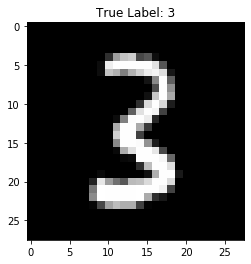

In [168]:
plt.imshow(xb[0].view(28,28))
plt.title(f"True Label: {yb[0]}")

In [169]:
model,opt = get_model()

#### `fit4()`

In [189]:
def fit4(epochs:int=2):
    for epoch in range(epochs):
        
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        
        running_loss = 0.0
        counter = 0
        
        for xb, yb in train_dl:
        
            preds = model(xb)
            loss = loss_func(preds, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()
            
            running_loss += loss.item() * xb.size(0)
            counter += 1
            
        
        epoch_loss = running_loss / data_range
        print('Training Loss: {:.4f}'.format(epoch_loss))
        print("="*10)

In [171]:
fit4()

Epoch 0/1
Training Loss: 21.1936
Epoch 1/1
Training Loss: 10.0820


In [172]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0327, grad_fn=<NllLossBackward>), tensor(1.))

### Tweak `tqdm`

Let's tweak the `fit4()` using `tqdm` like this [kaggle kernel](https://www.kaggle.com/abhishek/very-simple-pytorch-training-0-59) which is helpful.

#### `fit5()`

**Note:** Tweaking `tqdm` into `fit4()` we obtain the following `fit5()`

In [174]:
len(train_dl.dataset)

50000

In [198]:
n_batches = (n_data-1)// batch_sz + 1
n_data, batch_sz, n_data/batch_sz+1, n_batches

(50000, 64, 782.25, 782)

In [196]:
def fit5(epochs:int=2):
    for epoch in range(epochs):
        
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        
        running_loss = 0.0
        counter = 0
        
        n_batches =  (len(train_dl.dataset)-1)// batch_sz + 1 
        
        # creating tqdm object
        tk0 = tqdm.tqdm_notebook(train_dl, total=n_batches)
        
        for xb, yb in tk0:
        
            preds = model(xb)
            loss = loss_func(preds, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()
            
            running_loss += loss.item() * xb.size(0)
            counter += 1
            tk0.set_postfix(loss=(running_loss / (counter * train_dl.batch_sz)))
        
        epoch_loss = running_loss / data_range
        print('Training Loss: {:.4f}'.format(epoch_loss))
        print("="*10)

**Note:**

- Q. Why `len(train_dl.dataset)` returns the length of the dataset object from `class Dataset`
- A. In `class Dataset` we implemented the `dunder` method `__len__` which overwrite the `len()` method

In [197]:
fit5()

Epoch 0/1


Training Loss: 1.8867
Epoch 1/1


Training Loss: 1.6843


### Random DataLoader: Sampling

- We want our training set to be in a random order, and that order should differ each iteration. 
- But the _validation set shouldn't be randomized_.

#### Sampler

In [200]:
class Sampler():
    """
    Random permutation of the dataset indices based on the flag: shuffle
    """
    def __init__(self, dataset: Dataset, batch_sz:int, shuffle:bool=False):
        self.dataset_sz = len(dataset)
        self.batch_sz = batch_sz
        self.shuffle = shuffle
     
    def __iter__(self):
        """
        Returns: 
                a batch of randomized indices, 
        
        which are used in the dataloader to pick the original values 
        """
        
        if self.shuffle:
            self.idxs = torch.randperm(self.dataset_sz) 
        else: 
            self.idxs = torch.arange(self.dataset_sz)
        
        for i in range(0, self.dataset_sz, self.batch_sz):
            yield self.idxs[i:i+self.batch_sz]

In [201]:
small_ds = Dataset(*train_ds[:10])

In [204]:
# sampling WITHOUT shuffle. Initial order of indices in the chunk of batch size
s = Sampler(small_ds,3,False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [215]:
# sampling WITH shuffle. Random order of indices in the chunk of batch size
s = Sampler(small_ds,3,True)
[o for o in s]

[tensor([8, 6, 7]), tensor([4, 1, 5]), tensor([9, 3, 0]), tensor([2])]

**Question:**

- What is the purpose of `collate()`?

In [231]:
for o in s:
    print(o)
    b = small_ds[o]
    xbt, ybt = zip(b)
    print(ybt)

tensor([2, 7, 0])
(tensor([4, 3, 5]),)
tensor([9, 3, 8])
(tensor([4, 1, 1]),)
tensor([1, 5, 4])
(tensor([0, 2, 9]),)
tensor([6])
(tensor([1]),)


In [ ]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

class DataLoader():
    def __init__(self, ds: Dataset, sampler: Sampler, collate_fn=collate):
        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])